# All states

- For nut(3): 
    - nut on table
        - (peg in hole)
    - nut in jig
        - (pick and place)
    - nut in bin

- For bolt(4): 
    - bolt on table
        - (peg in hole)
    - bolt in jig
        - (screw)
    - bolt in nut
        - (pick_and_place)
    - bolt in bin
 
 ## This includes less states. But trajectories of actions might be needed. 

# All states

- For nut(4): 
    - nut on table
        - pick
    - nut picked up
        - move
    - nut over jig
        - peg
    - nut in jig

- For bolt(10): 
    - bolt on table
        - pick
    - bolt picked up
        - move
    - bolt over bolt hole 1
        - peg
    - bolt in jig
        - pick
    - bolt over bolt hole 2
        - move
    - bolt over nut hole 1
        - screw
    - bolt in nut
        - pick
    - bolt over nut hole 2
        - move
    - bolt over bin
        - place
    - bolt in bin
   
 ## This is more discrete. Less action prior needed. Harder to cluster due to more states. More huristics needed(eg. pick things up to some amount of hight). Suitable for first step.

## Make more states

In [1]:
%matplotlib notebook

# Load data
from torch import nn
import torch.nn.functional as F
import numpy as np
import torch
from torch.utils.data import DataLoader

x = np.load('../data/processed/x_processed.npy')
y = np.load('../data/processed/y_processed.npy')

x_extended = x
y_extended = y

for i, label in enumerate(y):
    if label ==  'Bolt on table':
        x_extended = np.concatenate((x_extended, (x[i,:] + np.array([0, 0.1, 0])).reshape(1,-1)), axis = 0)
        y_extended = np.concatenate((y_extended, ['Bolt picked']))
        
        x_extended = np.concatenate((x_extended, (x[i,:] + np.array([0.3, 0.13, 0.3])).reshape(1,-1)), axis = 0)
        y_extended = np.concatenate((y_extended, ['Bolt over bin']))
        
        x_extended = np.concatenate((x_extended, (x[i,:] + np.array([0.3, 0.03, 0.3])).reshape(1,-1)), axis = 0)
        y_extended = np.concatenate((y_extended, ['Bolt in bin']))
    elif label == 'Bolt in jig':
        x_extended = np.concatenate((x_extended, (x[i,:] + np.array([0, 0.05, 0])).reshape(1,-1)), axis = 0)
        y_extended = np.concatenate((y_extended, ['Bolt ready to insert']))
        
        x_extended = np.concatenate((x_extended, (x[i,:] + np.array([0, 0.1, 0])).reshape(1,-1)), axis = 0)
        y_extended = np.concatenate((y_extended, ['Bolt picked from jig']))
    elif label == 'Bolt assembled':
        x_extended = np.concatenate((x_extended, (x[i,:] + np.array([0, 0.05, 0])).reshape(1,-1)), axis = 0)
        y_extended = np.concatenate((y_extended, ['Bolt ready to assemble']))
        
        x_extended = np.concatenate((x_extended, (x[i,:] + np.array([0, 0.1, 0])).reshape(1,-1)), axis = 0)
        y_extended = np.concatenate((y_extended, ['Bolt assembled picked']))
        
     


# input_dim = x.shape[1] # data dimension
# output_dim = 10 # number of states

# # Make them tensors
# x = torch.from_numpy(x).view(-1,input_dim).float()
# y = torch.from_numpy(y.astype(int)).view(-1,1)


<IPython.core.display.Javascript object>


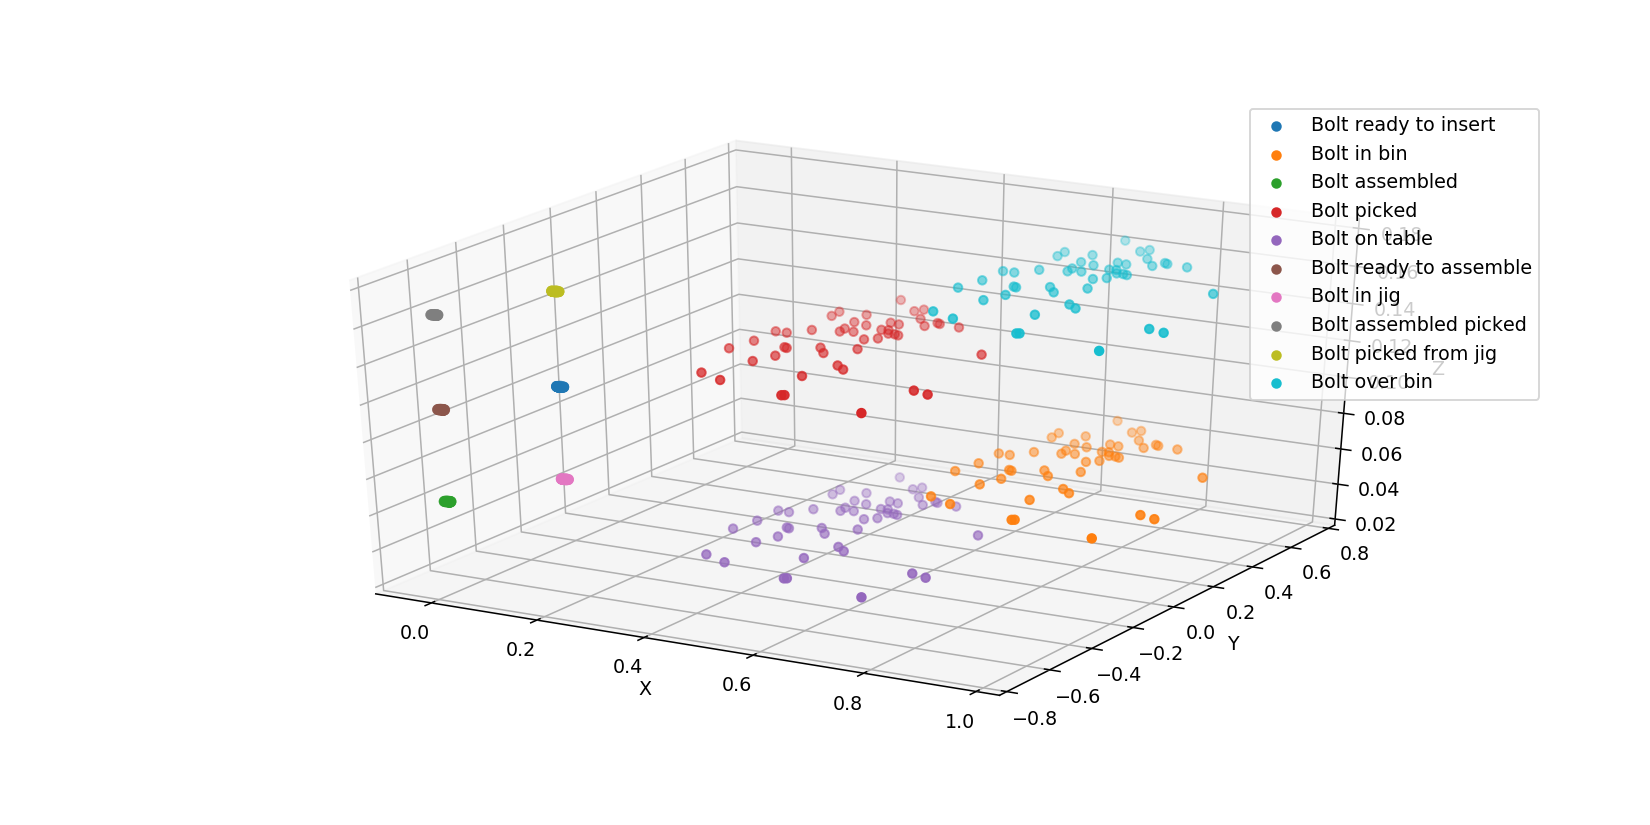

In [4]:
import sys
sys.path.append('..')
from utils.plotting import plot
from utils.data import label_to_int, divide_data
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt

fig = plt.figure(1, (12,6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
plot(ax, x_extended, y_extended)
plt.savefig('../figures/more_states.png')

In [3]:
labels = ['Bolt on table', 'Bolt in jig', 'Bolt assembled', 'Bolt picked', 'Bolt over bin', 'Bolt in bin',
          'Bolt ready to insert', 'Bolt picked from jig', 'Bolt ready to assemble', 'Bolt assembled picked']

y_extended_int = label_to_int(y_extended, labels)
n_training = 5
n_val = 15
x_train, y_train, x_left, y_left = divide_data(x_extended , y_extended_int, n_training)
x_val, y_val, x_test, y_test = divide_data(x_left, y_left, n_val)

x_train, y_train = torch.from_numpy(x_train).float(), torch.from_numpy(y_train.astype(int)).view(-1, 1).long()
x_val, y_val = torch.from_numpy(x_val).float(), torch.from_numpy(y_val.astype(int)).view(-1, 1).long()
x_test, y_test = torch.from_numpy(x_test).float(), torch.from_numpy(y_test.astype(int)).view(-1, 1).long()

print(y_train.shape, y_val.shape, y_test.shape)

torch.Size([50, 1]) torch.Size([150, 1]) torch.Size([253, 1])


In [4]:
# Define the network structure

class MyNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x


In [5]:
def train(x_train, y_train, net, criterion, optimizer, USE_GPU = True):
    n = x_train.shape[0]
    dim = x_train.shape[1]
    ind = torch.randperm(n)
    x_train = x_train[ind]
    y_train = y_train[ind]
    if USE_GPU:
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        net = net.cuda()
    for i in ind:
        x = x_train[i].view(-1, dim)
        y = y_train[i]
        net.zero_grad()
        output = net(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    return loss
    

def validate(x_val, y_val, net, criterion):
    val_loss = 0
    n = x_val.shape[0]
    with torch.no_grad():
        for i in range(n):
            x = x_val[i].view(-1, input_dim)
            y = torch.unsqueeze(y_val[i], 0)
            output = net(x)
            val_loss += criterion(output, y_val[i])    
        val_loss = val_loss / n
    return val_loss            

<IPython.core.display.Javascript object>


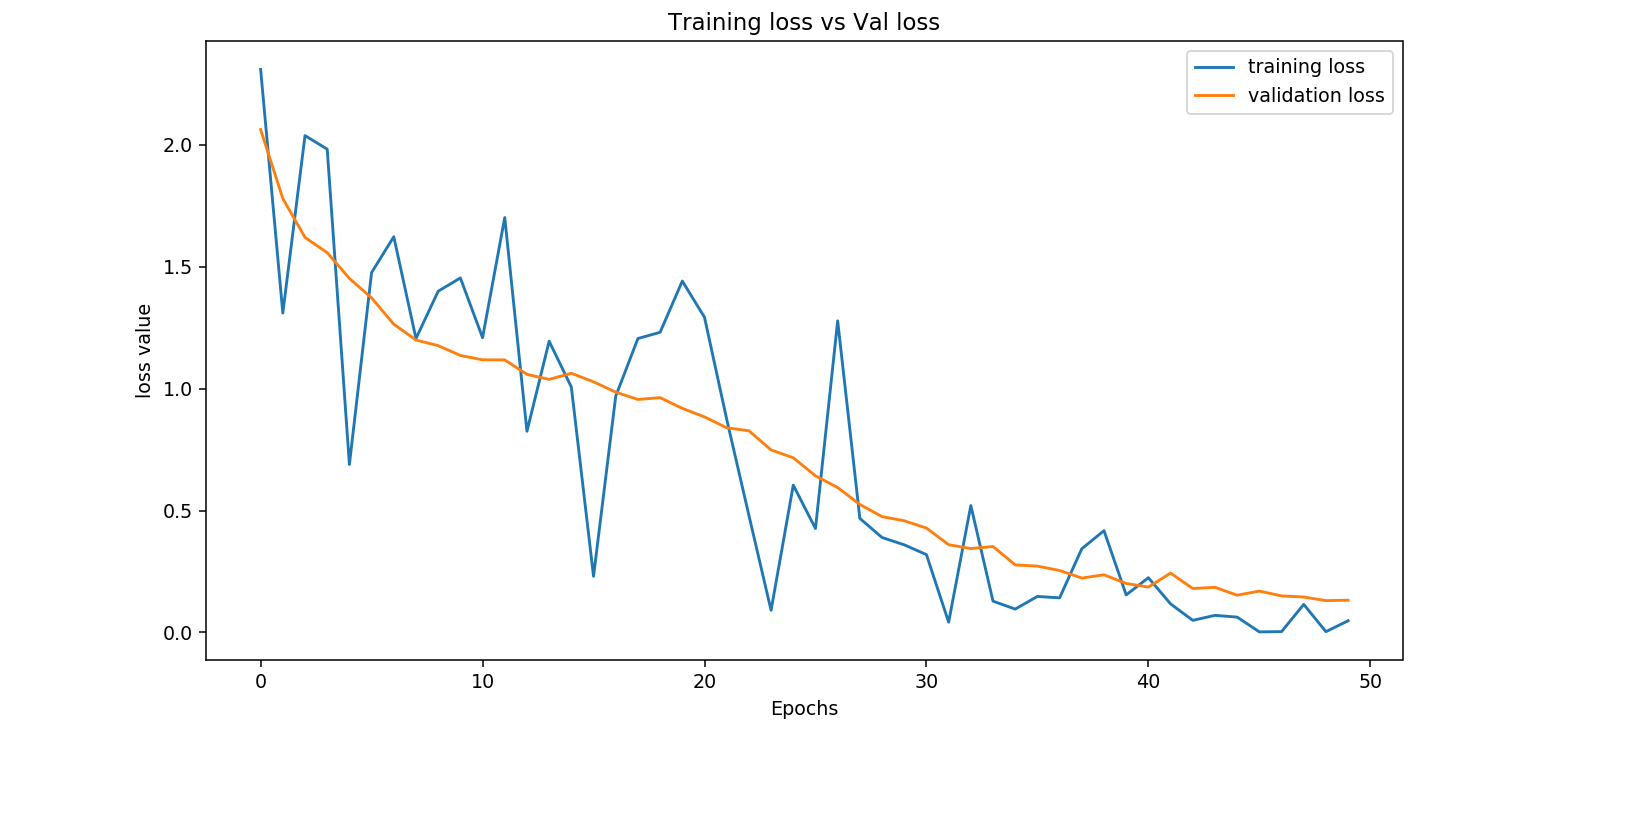

Epoch: 0 Loss: 2.3084299564361572
Epoch: 1 Loss: 1.3095276355743408
Epoch: 2 Loss: 2.0368130207061768
Epoch: 3 Loss: 1.9813737869262695
Epoch: 4 Loss: 0.6886265277862549
Epoch: 5 Loss: 1.4755983352661133
Epoch: 6 Loss: 1.6223516464233398
Epoch: 7 Loss: 1.2051366567611694
Epoch: 8 Loss: 1.398909091949463
Epoch: 9 Loss: 1.4534729719161987
Epoch: 10 Loss: 1.2084834575653076
Epoch: 11 Loss: 1.7010493278503418
Epoch: 12 Loss: 0.8248890042304993
Epoch: 13 Loss: 1.1941137313842773
Epoch: 14 Loss: 1.006395697593689
Epoch: 15 Loss: 0.23033952713012695
Epoch: 16 Loss: 0.968640923500061
Epoch: 17 Loss: 1.2050728797912598
Epoch: 18 Loss: 1.230661392211914
Epoch: 19 Loss: 1.4406907558441162
Epoch: 20 Loss: 1.2920737266540527
Epoch: 21 Loss: 0.8742327690124512
Epoch: 22 Loss: 0.48044252395629883
Epoch: 23 Loss: 0.09095335006713867
Epoch: 24 Loss: 0.6041922569274902
Epoch: 25 Loss: 0.42617595195770264
Epoch: 26 Loss: 1.277450680732727
Epoch: 27 Loss: 0.46756672859191895
Epoch: 28 Loss: 0.389437854290

In [6]:
import torch.optim as optim

input_dim = x.shape[1] # data dimension
output_dim = 10 # number of states
net = MyNet(input_dim, output_dim)
optimizer = optim.Adam(net.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

epoches = 50

train_loss_list = []
val_loss_list = []

fig = plt.figure(2, figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax = fig.add_subplot(1,1,1)

for e in range(epoches):
    train_loss = train(x_train, y_train, net.train(), criterion, optimizer)
    train_loss_list.append(train_loss)
    val_loss = validate(x_val.cuda(), y_val.cuda(), net.eval(), criterion)
    val_loss_list.append(val_loss)
    ax.clear()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss vs Val loss')
    ax.plot(train_loss_list, label='training loss')
    ax.plot(val_loss_list, label='validation loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()
    print("Epoch: {} Loss: {}".format(e, train_loss))

In [7]:
def predict(x, net):
    with torch.no_grad():
        output = net(x)
        return torch.argmax(output)

def test(x_test, y_test, net, USE_GPU = True):
    n = x_test.shape[0]
    predictions = torch.zeros(n).long()
    if USE_GPU:
        x_test = x_test.cuda()
        net = net.cuda()
    with torch.no_grad():
        for i in range(n):
            prediction = predict(x_test[i,:], net)
            predictions[i] = prediction
    accuracy = int(sum(predictions.detach() == y_test.flatten())) / n 
    return predictions, accuracy

In [8]:
predictions, accuracy = test(x_test, y_test, net.eval())

In [9]:
accuracy

0.9723320158102767

<IPython.core.display.Javascript object>


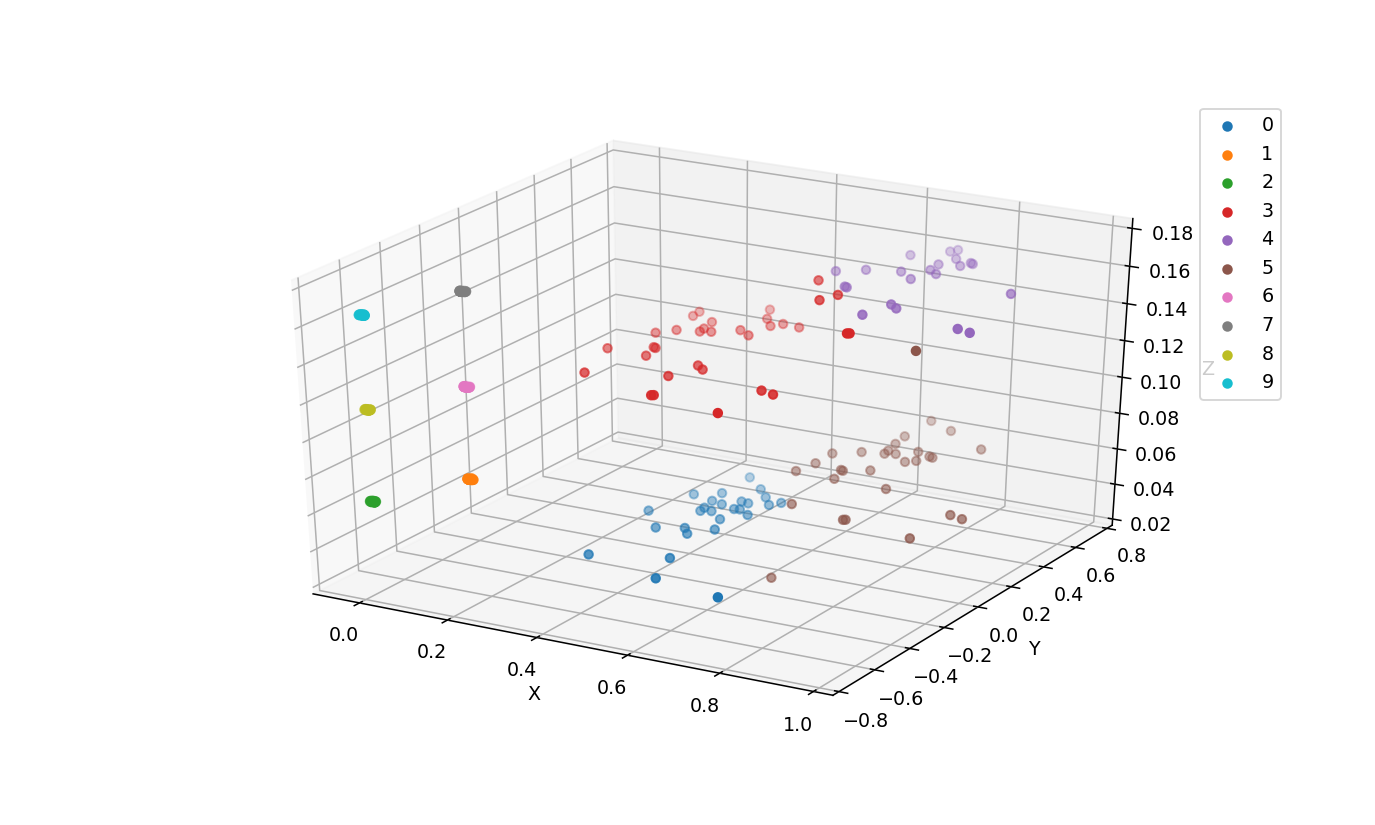

In [10]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(3, figsize=(10,6))
ax = fig.add_subplot(1,1,1, projection='3d')
plot(ax, x_test, predictions.numpy())

# Next step: try ssp encoding

## Encode to ssp

In [11]:
from utils.encoding import encode_dataset, make_good_unitary

dim = 256
x_axis_sp = make_good_unitary(dim)
y_axis_sp = make_good_unitary(dim)
z_axis_sp = make_good_unitary(dim)

x_train_ssp = torch.FloatTensor(encode_dataset(x_train, x_axis_sp, y_axis_sp, z_axis_sp))
x_val_ssp = torch.FloatTensor(encode_dataset(x_val, x_axis_sp, y_axis_sp, z_axis_sp))
x_test_ssp = torch.FloatTensor(encode_dataset(x_test, x_axis_sp, y_axis_sp, z_axis_sp))

## Create dataset

In [12]:
from torch.utils.data import Dataset, DataLoader

class Mydata(Dataset):
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __getitem__(self, ind):
        return self.x[ind], self.y[ind]
    
    def __len__(self):
        return len(self.x)

data = Mydata(torch.FloatTensor(x_train_ssp), y_train)

## Batch data

In [13]:
train_loader = DataLoader(data, batch_size = 1, shuffle = True)

## Structure of sspNet

In [14]:
class sspNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x


## Define train

In [15]:
def train(dataloader, net, criterion, optimizer, USE_GPU = True):
    for i, data in enumerate(dataloader):
        x, y = data
        if USE_GPU:
            x = x.cuda()
            y = y.cuda()
            net = net.cuda()
        net.zero_grad()
        output = net(x)
        loss = criterion(output, y.flatten())
        loss.backward()
        optimizer.step()
        return loss

def validate(x_val, y_val, net, criterion):
    val_loss = 0
    n = x_val.shape[0]
    d = x_val.shape[1]
    with torch.no_grad():
        for i in range(n):
            x = x_val[i].view(-1, d)
            output = net(x)
            val_loss += criterion(output, y_val[i])    
        val_loss = val_loss / n
    return val_loss            

## Train

<IPython.core.display.Javascript object>


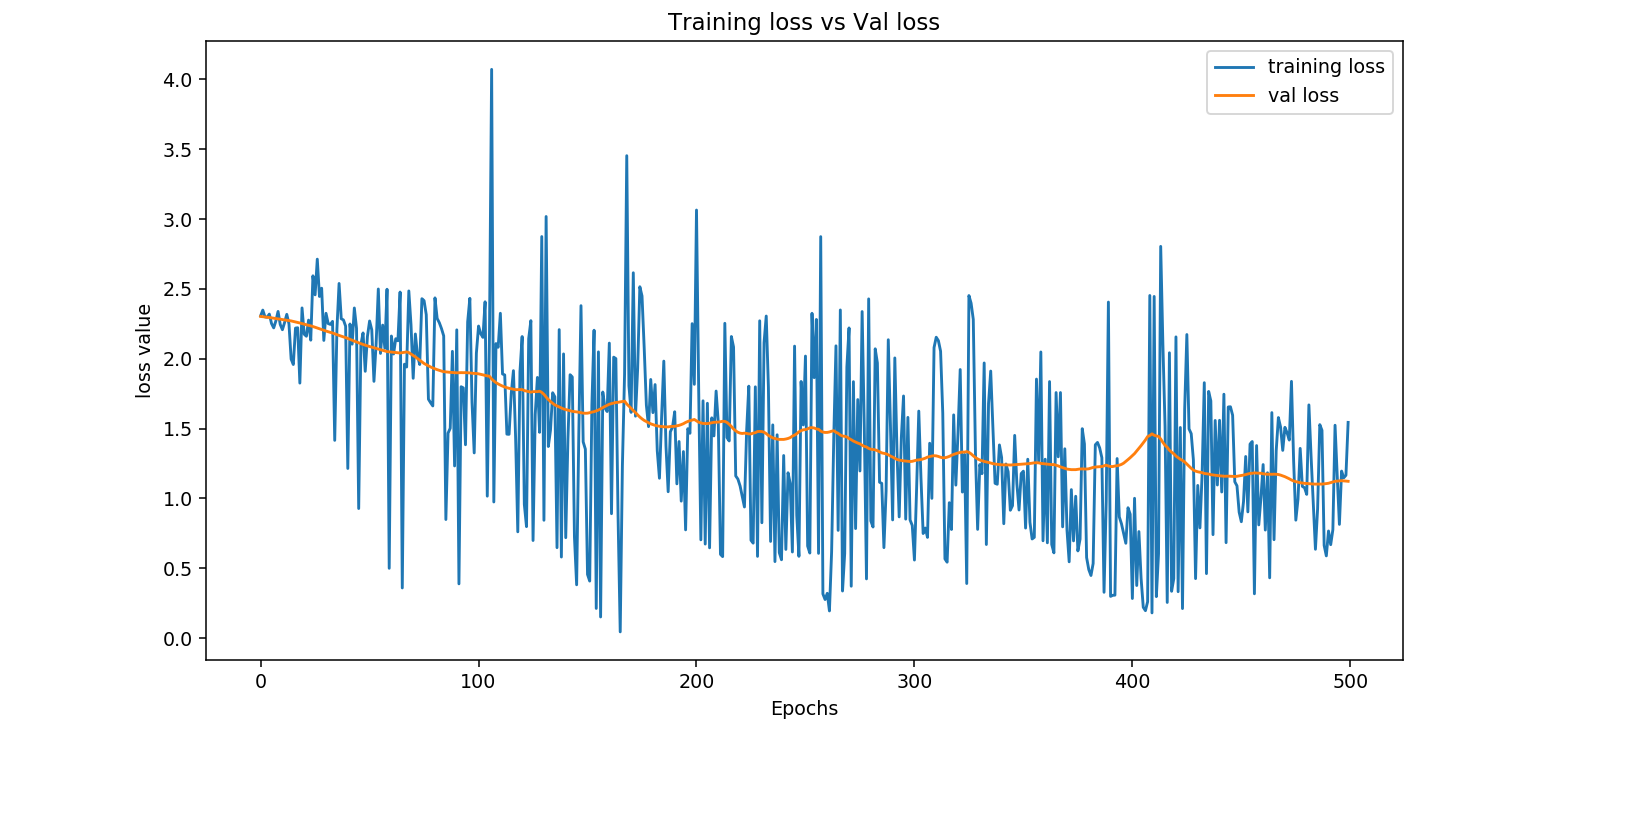

Epoch: 0 Loss: 2.3073034286499023
Epoch: 1 Loss: 2.348104476928711
Epoch: 2 Loss: 2.299806594848633
Epoch: 3 Loss: 2.2975170612335205
Epoch: 4 Loss: 2.319594144821167
Epoch: 5 Loss: 2.2522635459899902
Epoch: 6 Loss: 2.2209620475769043
Epoch: 7 Loss: 2.2711021900177
Epoch: 8 Loss: 2.338636636734009
Epoch: 9 Loss: 2.2453527450561523
Epoch: 10 Loss: 2.2079591751098633
Epoch: 11 Loss: 2.259587526321411
Epoch: 12 Loss: 2.3178062438964844
Epoch: 13 Loss: 2.250068187713623
Epoch: 14 Loss: 1.997556447982788
Epoch: 15 Loss: 1.9588038921356201
Epoch: 16 Loss: 2.2193424701690674
Epoch: 17 Loss: 2.221790313720703
Epoch: 18 Loss: 1.8257887363433838
Epoch: 19 Loss: 2.3637924194335938
Epoch: 20 Loss: 2.1755218505859375
Epoch: 21 Loss: 2.1610825061798096
Epoch: 22 Loss: 2.276515007019043
Epoch: 23 Loss: 2.133017063140869
Epoch: 24 Loss: 2.5937089920043945
Epoch: 25 Loss: 2.457425117492676
Epoch: 26 Loss: 2.712892770767212
Epoch: 27 Loss: 2.445751190185547
Epoch: 28 Loss: 2.504865884780884
Epoch: 29 Lo

Epoch: 233 Loss: 1.7947547435760498
Epoch: 234 Loss: 0.692652702331543
Epoch: 235 Loss: 1.5265965461730957
Epoch: 236 Loss: 0.5483205318450928
Epoch: 237 Loss: 1.45578134059906
Epoch: 238 Loss: 0.6120237112045288
Epoch: 239 Loss: 0.5613530874252319
Epoch: 240 Loss: 1.3075318336486816
Epoch: 241 Loss: 0.6354037523269653
Epoch: 242 Loss: 1.1839606761932373
Epoch: 243 Loss: 1.1081143617630005
Epoch: 244 Loss: 0.6169396638870239
Epoch: 245 Loss: 2.0903842449188232
Epoch: 246 Loss: 0.8805530071258545
Epoch: 247 Loss: 0.585913896560669
Epoch: 248 Loss: 1.8374273777008057
Epoch: 249 Loss: 1.5260950326919556
Epoch: 250 Loss: 2.019190549850464
Epoch: 251 Loss: 0.6594747304916382
Epoch: 252 Loss: 0.609420657157898
Epoch: 253 Loss: 2.325361967086792
Epoch: 254 Loss: 1.8648284673690796
Epoch: 255 Loss: 2.281403064727783
Epoch: 256 Loss: 0.6071622371673584
Epoch: 257 Loss: 2.874002456665039
Epoch: 258 Loss: 0.3170933723449707
Epoch: 259 Loss: 0.27692389488220215
Epoch: 260 Loss: 0.321208119392395
E

In [16]:
import torch.optim as optim

output_dim = 10
epoches = 500
net_ssp = sspNet(dim, output_dim)
optimizer = optim.Adam(net_ssp.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

fig = plt.figure(4, figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax = fig.add_subplot(1,1,1)
val_loss_ssp_list = []
train_loss_ssp_list = []
for e in range(epoches):
    if e > 500:
        optimizer = optim.Adam(net_ssp.parameters(), lr = 0.0001)
    train_loss = train(train_loader, net_ssp.train(), criterion, optimizer)
    train_loss_ssp_list.append(train_loss)
    val_loss = validate(x_val_ssp.cuda(), y_val.cuda(), net_ssp.eval(), criterion)
    val_loss_ssp_list.append(val_loss) 
    ax.clear()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss vs Val loss')
    ax.plot(train_loss_ssp_list, label='training loss')
    ax.plot(val_loss_ssp_list, label='val loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()
    print("Epoch: {} Loss: {}".format(e, train_loss))


# Test

## Define Test

In [17]:
def predict(x, net):
    with torch.no_grad():
        output = net(x)
        return torch.argmax(output)

def test(x_test, y_test, net, USE_GPU = True):
    n = x_test.shape[0]
    predictions = torch.zeros(n).long()
    if USE_GPU:
        x_test = x_test.cuda()
        net = net.cuda()
    with torch.no_grad():
        for i in range(n):
            prediction = predict(x_test[i,:], net)
            predictions[i] = prediction
    accuracy = int(sum(predictions.detach() == y_test.flatten())) / n 
    return predictions, accuracy

In [18]:
predictions_ssp, accuracy_ssp = test(x_test_ssp, y_test, net_ssp.eval())
print(accuracy_ssp)

0.4189723320158103


<IPython.core.display.Javascript object>


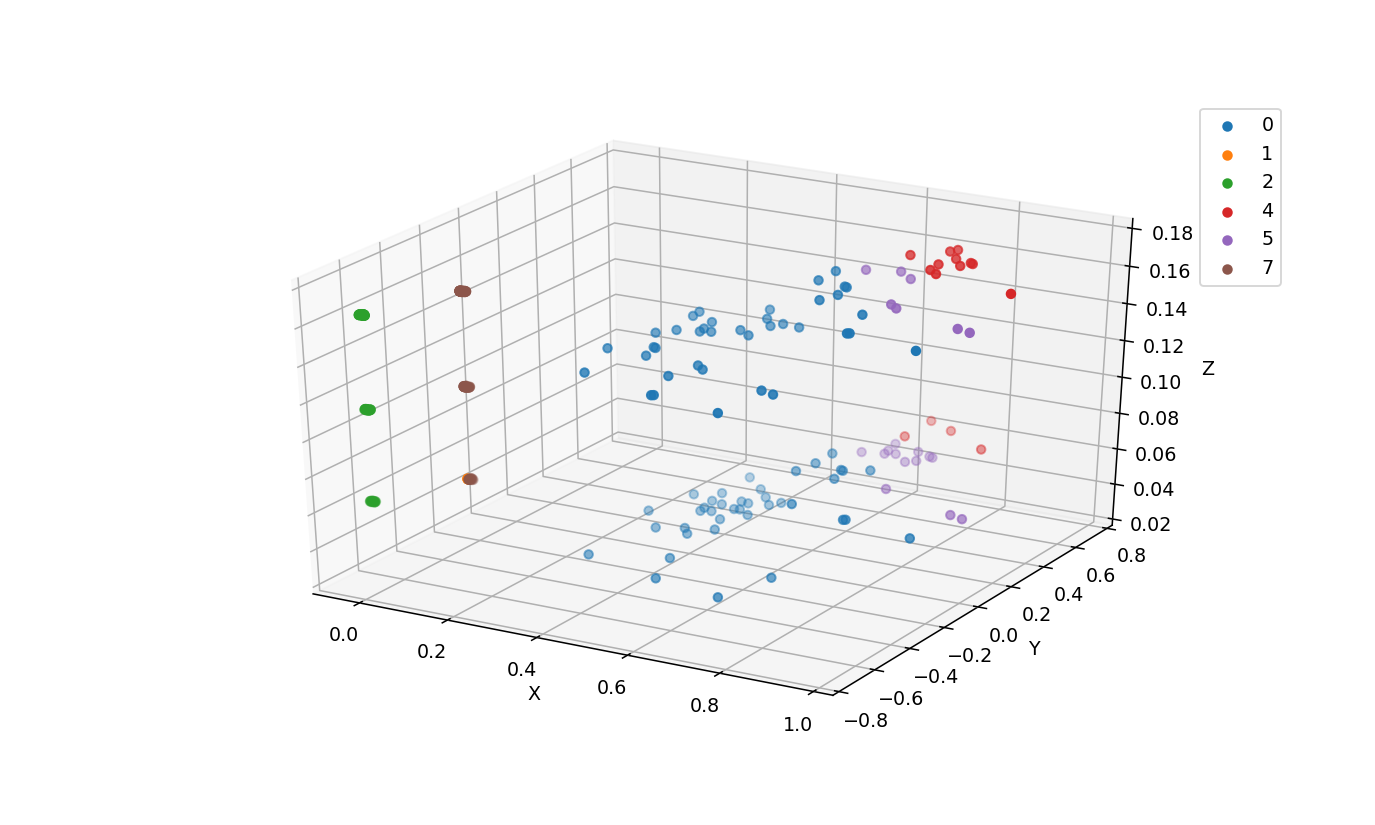

In [19]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(5, figsize=(10,6))
ax = fig.add_subplot(1,1,1, projection='3d')
plot(ax, x_test, predictions_ssp.numpy())

# Note:

- SSP does not work so far
- Get better code though
- Use dataloader and dataset for batch and more data
- TODO fix test function above


# Try train with more data

In [20]:
from scipy.stats import trim_mean
from sklearn.covariance import MinCovDet

def build_model(estimated_labels, data_concat):
    models = []
    # model the distribution of each cluster robustly in case there are misclassifications
    for label in np.unique(estimated_labels):
        indices = np.nonzero(estimated_labels == label)
        samples = data_concat[indices,:].squeeze()
        if samples.ndim == 1:
            means = samples
            covariance = np.zeros((3,3))
        else:
            means = trim_mean(samples, 0, axis=0)
            mcd = MinCovDet(support_fraction=1).fit(samples)
            covariance = mcd.covariance_
        models.append([means, covariance, label - min(estimated_labels)])
    return models

In [21]:
models = build_model(y_train.flatten(), x_train)

In [22]:
n_samples = 1000
x_train_gen = []
y_train_gen = []
for model in models:
    x_train_gen.append(np.random.multivariate_normal(model[0][:3] , model[1][:3,:3] , n_samples))
    y_train_gen += [model[2]] * n_samples 
x_train_gen = torch.FloatTensor(x_train_gen).view(-1, 3)
y_train_gen = torch.LongTensor(y_train_gen).view(-1,1)
print(x_train_gen.shape, y_train_gen.shape)

torch.Size([10000, 3]) torch.Size([10000, 1])


In [23]:
x_train_gen.shape

torch.Size([10000, 3])

## 2D encoding

In [24]:
data = Mydata(torch.FloatTensor(x_train_gen), y_train_gen)
train_loader_gen = DataLoader(data, batch_size = 32, shuffle = True)

<IPython.core.display.Javascript object>


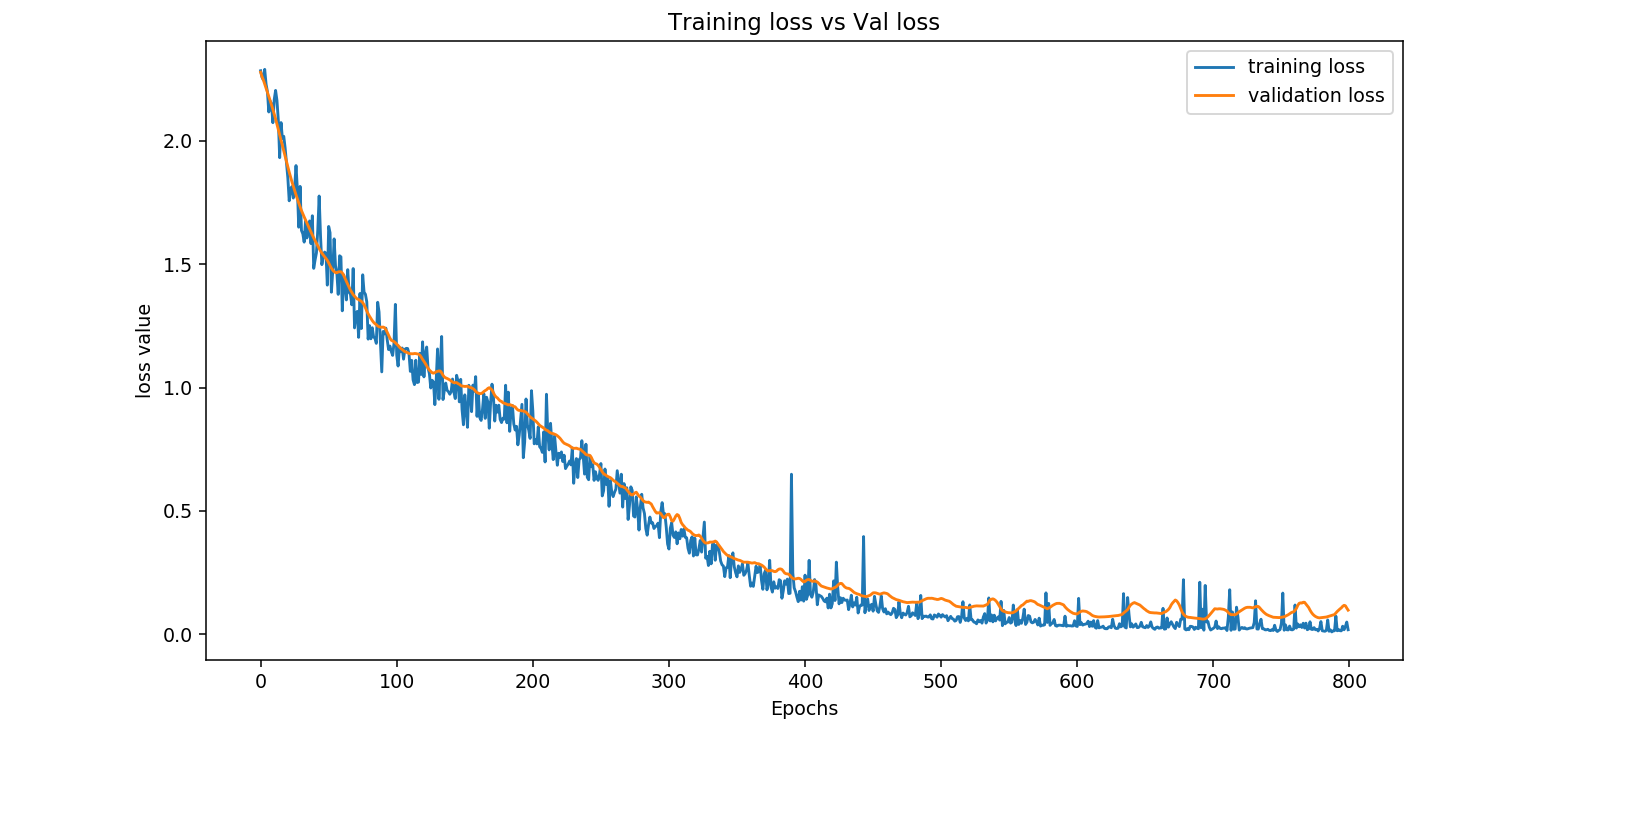

Epoch: 0 Loss: 2.283946990966797
Epoch: 1 Loss: 2.2578179836273193
Epoch: 2 Loss: 2.2470760345458984
Epoch: 3 Loss: 2.2895798683166504
Epoch: 4 Loss: 2.229689359664917
Epoch: 5 Loss: 2.198802947998047
Epoch: 6 Loss: 2.1168651580810547
Epoch: 7 Loss: 2.160871744155884
Epoch: 8 Loss: 2.1490092277526855
Epoch: 9 Loss: 2.0734009742736816
Epoch: 10 Loss: 2.1676199436187744
Epoch: 11 Loss: 2.2043190002441406
Epoch: 12 Loss: 2.1634366512298584
Epoch: 13 Loss: 2.0835840702056885
Epoch: 14 Loss: 1.9316153526306152
Epoch: 15 Loss: 2.0738625526428223
Epoch: 16 Loss: 2.009220838546753
Epoch: 17 Loss: 2.018047332763672
Epoch: 18 Loss: 1.9713209867477417
Epoch: 19 Loss: 1.909287691116333
Epoch: 20 Loss: 1.8495187759399414
Epoch: 21 Loss: 1.7568144798278809
Epoch: 22 Loss: 1.803739070892334
Epoch: 23 Loss: 1.8145668506622314
Epoch: 24 Loss: 1.7680578231811523
Epoch: 25 Loss: 1.8103930950164795
Epoch: 26 Loss: 1.8996132612228394
Epoch: 27 Loss: 1.8035469055175781
Epoch: 28 Loss: 1.6498483419418335
Epo

Epoch: 455 Loss: 0.11378359794616699
Epoch: 456 Loss: 0.15559275448322296
Epoch: 457 Loss: 0.10289587080478668
Epoch: 458 Loss: 0.08984740078449249
Epoch: 459 Loss: 0.10340909659862518
Epoch: 460 Loss: 0.08249518275260925
Epoch: 461 Loss: 0.08969272673130035
Epoch: 462 Loss: 0.08346535265445709
Epoch: 463 Loss: 0.07916243374347687
Epoch: 464 Loss: 0.0865166112780571
Epoch: 465 Loss: 0.10510776937007904
Epoch: 466 Loss: 0.10039295256137848
Epoch: 467 Loss: 0.06727971136569977
Epoch: 468 Loss: 0.07686358690261841
Epoch: 469 Loss: 0.13180691003799438
Epoch: 470 Loss: 0.083852618932724
Epoch: 471 Loss: 0.06674019247293472
Epoch: 472 Loss: 0.08583924919366837
Epoch: 473 Loss: 0.08087261021137238
Epoch: 474 Loss: 0.07777737081050873
Epoch: 475 Loss: 0.08803193271160126
Epoch: 476 Loss: 0.1131705790758133
Epoch: 477 Loss: 0.07043120265007019
Epoch: 478 Loss: 0.07482202351093292
Epoch: 479 Loss: 0.08681287616491318
Epoch: 480 Loss: 0.0815916508436203
Epoch: 481 Loss: 0.07579776644706726
Epoch:

In [25]:
import torch.optim as optim

input_dim = x_train_gen.shape[1] # data dimension
output_dim = 10 # number of states
net = MyNet(input_dim, output_dim)
optimizer = optim.Adam(net.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

epoches = 800

train_loss_list = []
val_loss_list = []

fig = plt.figure(6, figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax = fig.add_subplot(1,1,1)

for e in range(epoches):
    train_loss = train(train_loader_gen, net.train(), criterion, optimizer)
    train_loss_list.append(train_loss)
    val_loss = validate(x_val.cuda(), y_val.cuda(), net.eval(), criterion)
    val_loss_list.append(val_loss)
    ax.clear()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss vs Val loss')
    ax.plot(train_loss_list, label='training loss')
    ax.plot(val_loss_list, label='validation loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()
    print("Epoch: {} Loss: {}".format(e, train_loss))

In [26]:
predictions, accuracy = test(x_test, y_test, net.eval())
print(accuracy)

0.9762845849802372


In [27]:
x_train_gen_ssp = encode_dataset(x_train_gen, x_axis_sp, y_axis_sp, z_axis_sp)
data = Mydata(torch.FloatTensor(x_train_gen_ssp), y_train_gen)
train_loader_gen_ssp = DataLoader(data, batch_size = 32, shuffle = True)

<IPython.core.display.Javascript object>


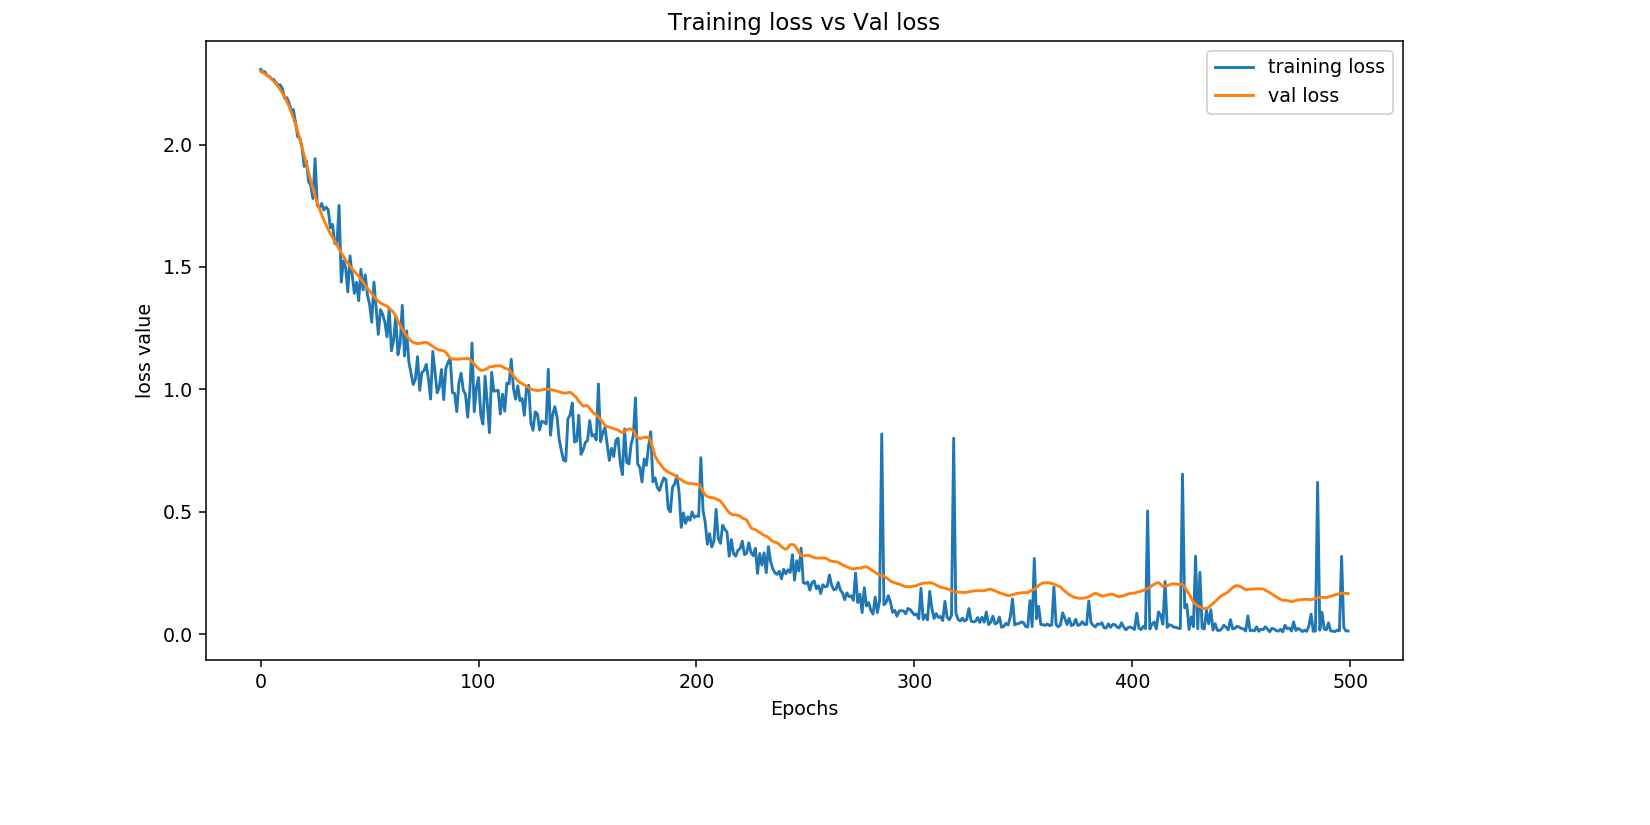

Epoch: 0 Loss: 2.3071696758270264
Epoch: 1 Loss: 2.2965400218963623
Epoch: 2 Loss: 2.2971644401550293
Epoch: 3 Loss: 2.2811331748962402
Epoch: 4 Loss: 2.278589963912964
Epoch: 5 Loss: 2.2679495811462402
Epoch: 6 Loss: 2.2659342288970947
Epoch: 7 Loss: 2.25241756439209
Epoch: 8 Loss: 2.2438769340515137
Epoch: 9 Loss: 2.2435505390167236
Epoch: 10 Loss: 2.2278926372528076
Epoch: 11 Loss: 2.1890108585357666
Epoch: 12 Loss: 2.19197416305542
Epoch: 13 Loss: 2.171215772628784
Epoch: 14 Loss: 2.1406784057617188
Epoch: 15 Loss: 2.1431148052215576
Epoch: 16 Loss: 2.090650796890259
Epoch: 17 Loss: 2.0321860313415527
Epoch: 18 Loss: 2.026512622833252
Epoch: 19 Loss: 1.986918330192566
Epoch: 20 Loss: 1.9108482599258423
Epoch: 21 Loss: 1.931228518486023
Epoch: 22 Loss: 1.8495349884033203
Epoch: 23 Loss: 1.8334319591522217
Epoch: 24 Loss: 1.7795270681381226
Epoch: 25 Loss: 1.9427738189697266
Epoch: 26 Loss: 1.7511131763458252
Epoch: 27 Loss: 1.7413309812545776
Epoch: 28 Loss: 1.7597856521606445
Epoch

Epoch: 452 Loss: 0.012932032346725464
Epoch: 453 Loss: 0.07467903196811676
Epoch: 454 Loss: 0.01416885107755661
Epoch: 455 Loss: 0.016599655151367188
Epoch: 456 Loss: 0.013095997273921967
Epoch: 457 Loss: 0.030183985829353333
Epoch: 458 Loss: 0.011637024581432343
Epoch: 459 Loss: 0.020393669605255127
Epoch: 460 Loss: 0.018369831144809723
Epoch: 461 Loss: 0.03024829924106598
Epoch: 462 Loss: 0.021211110055446625
Epoch: 463 Loss: 0.009735822677612305
Epoch: 464 Loss: 0.02367391437292099
Epoch: 465 Loss: 0.021332673728466034
Epoch: 466 Loss: 0.014498904347419739
Epoch: 467 Loss: 0.012522213160991669
Epoch: 468 Loss: 0.019935287535190582
Epoch: 469 Loss: 0.009404927492141724
Epoch: 470 Loss: 0.03615559637546539
Epoch: 471 Loss: 0.022561751306056976
Epoch: 472 Loss: 0.02509908378124237
Epoch: 473 Loss: 0.012725308537483215
Epoch: 474 Loss: 0.04979260638356209
Epoch: 475 Loss: 0.015054658055305481
Epoch: 476 Loss: 0.023939698934555054
Epoch: 477 Loss: 0.01833558827638626
Epoch: 478 Loss: 0.0

In [28]:
output_dim = 10
epoches = 500
net_ssp = sspNet(dim, output_dim)
optimizer = optim.Adam(net_ssp.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

fig = plt.figure(7, figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax = fig.add_subplot(1,1,1)
val_loss_ssp_list = []
train_loss_ssp_list = []
for e in range(epoches):
    if e > 500:
        optimizer = optim.Adam(net_ssp.parameters(), lr = 0.0001)
    train_loss = train(train_loader_gen_ssp, net_ssp.train(), criterion, optimizer)
    train_loss_ssp_list.append(train_loss)
    val_loss = validate(x_val_ssp.cuda(), y_val.cuda(), net_ssp.eval(), criterion)
    val_loss_ssp_list.append(val_loss) 
    ax.clear()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss vs Val loss')
    ax.plot(train_loss_ssp_list, label='training loss')
    ax.plot(val_loss_ssp_list, label='val loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()
    print("Epoch: {} Loss: {}".format(e, train_loss))

In [29]:
predictions, accuracy = test(x_test_ssp, y_test, net_ssp.eval())
print(accuracy)

0.9565217391304348
